---
# 특강 프로젝트 DQN
---

- cartpole, mountaincar, acrobot 
dqn, pg, actor-critic 까지 돌리고 분석(plot, board)
- ppt 순서는 강화학습 소개 - gym 소개 - 실습 별 환경 및 이론 소개 - 실습
- correlation, non stationary target 때문에 simple 한 q - learning 은 잘 안됨
---

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import gym
import tensorflow as tf
import random
import numpy as np
from collections import deque
import dqn

In [2]:
import sys

---
# simple Q learning
---

In [3]:
env = gym.make('CartPole-v1')

In [4]:
size_s = env.observation_space.shape[0]
size_w1 = 8
size_w2 = 20
size_w3 = 10
size_out = env.action_space.n
lr = .1 ##Learning rate
total_episode = 500
epsilon = .1
gamma = .95 ##discount factor

STATE_IN = tf.placeholder(tf.float32, shape=[None, size_s])
targetQ = tf.placeholder(tf.float32, shape=[None, size_out])
W_1 = tf.Variable(tf.random_normal([size_s, size_w1]))
W_2 = tf.Variable(tf.random_normal([size_w1, size_w2]))
W_3 = tf.Variable(tf.random_normal([size_w2, size_w3]))
OUT = tf.Variable(tf.random_normal([size_w3, size_out]))

In [5]:
L_1 = (tf.matmul(STATE_IN, W_1))
L_2 = (tf.matmul(L_1, W_2))
L_3 = tf.matmul(L_2, W_3)
Qout = (tf.matmul(L_3, OUT))
loss = tf.reduce_mean(tf.square(Qout - targetQ))
optimizer = tf.train.AdamOptimizer(lr).minimize(loss)

In [6]:
# 그래프 그리는 함수
def make_graph(x, y):
    plt.ion()
    fig = plt.figure()
    sp = fig.add_subplot(111)
    plt.xlim([0, 2000])
    plt.ylim([0, 2000])
    line, = plt.plot(x, y, 'b')
    sp.set_xlabel('episode')
    sp.set_ylabel('reward')
    return fig, sp, line

<IPython.core.display.Javascript object>


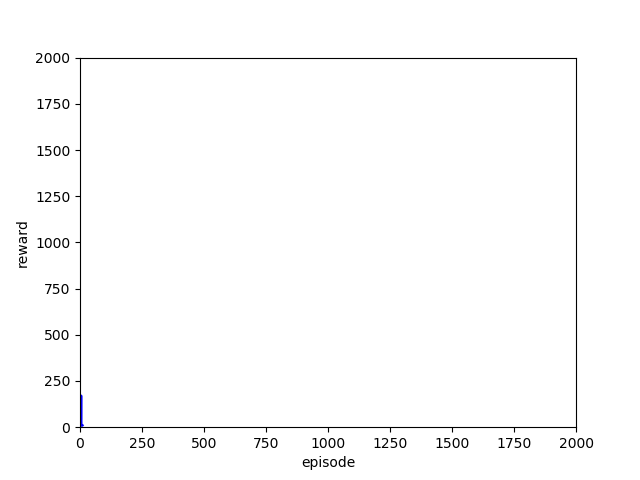

episode 1, score : 12 
episode 2, score : 9 
episode 3, score : 21 
episode 4, score : 44 
episode 5, score : 171 
episode 6, score : 9 
episode 7, score : 10 
episode 8, score : 9 
episode 9, score : 9 
episode 10, score : 8 
episode 11, score : 10 


KeyboardInterrupt: 

In [7]:
init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    state = env.reset()
    ep = 1
    step = 0
    total_reward = 0
    
     # 그래프 생성
    x_data = []
    y_data = []
    fig, sp, line = make_graph(x_data, y_data)
    
    while ep < total_episode:
        step += 1
        #env.render() 
        state = np.reshape(state, newshape=[1, size_s])
        Q_prev = sess.run(Qout, feed_dict={STATE_IN:state})
        
        if random.random() < epsilon:
            action = env.action_space.sample()
        else:
            action = np.argmax(Q_prev)
            
        new_state, r, d, _ = env.step(action)

        if d:
            # 그래프 그리기
            x_data.append(ep)
            y_data.append(step)

            line.set_xdata(x_data)
            line.set_ydata(y_data)
            fig.canvas.draw()
            
            target[0,action] = -100        # - 보상(벌) 을 주어서 그 액션은 하지 않도록 강화한다.
            epsilon = 1./((ep/50) + 10)
            print("episode {}, score : {} ".format(ep, step))
            step = 0
            ep += 1
            state = env.reset()
        else:
            new_state = np.reshape(new_state, newshape=[1, size_s])
            Q_cur = sess.run(Qout, feed_dict={STATE_IN:new_state})
            target = Q_prev
            target[0,action] = r + gamma*np.argmax(Q_cur)

            sess.run(optimizer, feed_dict={targetQ:target, STATE_IN:state})
            state = new_state
            
env.close()

In [14]:
import io
import base64
from IPython.display import HTML

video = io.open('C:\\Users\\김민수\\Documents\\Bandicam\\cartpole_q.mp4', 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<video alt="test" controls>
<source src="data:video/mp4;base64,{0}" type="video/mp4" /> </video>'''.format(encoded.decode('ascii')))

---
# DQN
- 이 case 에서는 2 층의 hidden layer 를 두었다.
- 각 층 마다 tanh 활성화 함수를 두었다
- 변수들은 초기화는 xavier 초기화 방식으로 했다. 비선형 활성화 함수일 때 성능이 좋은 경향이 있다. (분산 = sqrt(2 / 입력변수 갯수 + 출력변수 갯수))
---

In [8]:
'''
target 네트워크를 복사하는 함수
''' 
def copy(*, dest_scope_name = 'target', src_scope_name = 'main') :
    op_holder = []
    
    src_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope = src_scope_name)
    dest_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope = dest_scope_name)
    
    for src_var, dest_var in zip(src_vars, dest_vars) :
        op_holder.append(dest_var.assign(src_var))
        
    return op_holder


In [9]:
'''
과거 경험 중 랜덤으로 몇 개 뽑아 학습한다.
'''
def replay_train(mainDQN, targetDQN, train_batch) :
    x_stack = np.empty(0).reshape(0, size_s)
    y_stack = np.empty(0).reshape(0, size_out)
    
    for state, action, reward, next_state, done in train_batch :
        Q = mainDQN.predict(state)
        
        if done :
            Q[0, action] = -100
        
        else :
            Q[0, action] = reward + gamma*np.max(targetDQN.predict(next_state))
        
        x_stack = np.vstack([x_stack, state])
        y_stack = np.vstack([y_stack, Q])
        
    return mainDQN.update(x_stack, y_stack)

<IPython.core.display.Javascript object>


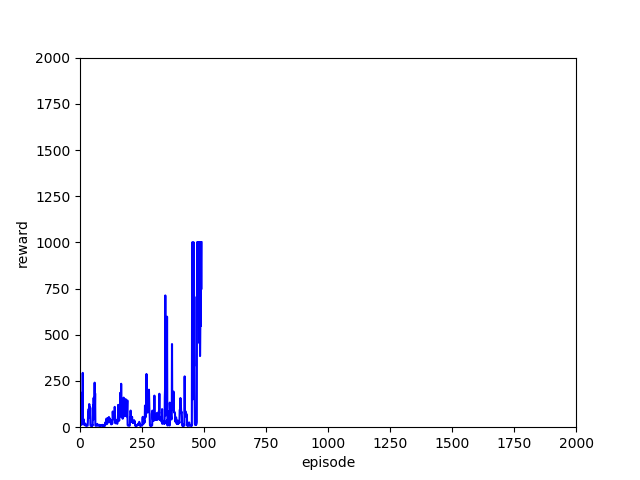

episode : 0, steps : 30
episode : 1, steps : 26
loss : 482.22958
episode : 2, steps : 29
episode : 3, steps : 15
episode : 4, steps : 92
episode : 5, steps : 38
episode : 6, steps : 13
episode : 7, steps : 57
episode : 8, steps : 91
episode : 9, steps : 187
episode : 10, steps : 49
episode : 11, steps : 294
loss : 0.7097645
episode : 12, steps : 16
episode : 13, steps : 18
episode : 14, steps : 44
episode : 15, steps : 15
episode : 16, steps : 19
episode : 17, steps : 25
episode : 18, steps : 15
episode : 19, steps : 16
episode : 20, steps : 19
episode : 21, steps : 16
loss : 1.5714588
episode : 22, steps : 9
episode : 23, steps : 10
episode : 24, steps : 15
episode : 25, steps : 10
episode : 26, steps : 12
episode : 27, steps : 9
episode : 28, steps : 9
episode : 29, steps : 8
episode : 30, steps : 8
episode : 31, steps : 9
loss : 1.7488537
episode : 32, steps : 44
episode : 33, steps : 77
episode : 34, steps : 90
episode : 35, steps : 99
episode : 36, steps : 50
episode : 37, steps :

In [10]:
total_episode = 1000
replay_buffer = deque()
ep = 0
step = 0
saver = tf.train.Saver()
save_file = 'C:\\Users\\김민수\\Documents\\GitHub\\RL\\vars\\cartpole_dqn'
mean_reward = deque()

with tf.Session() as sess:
      
    # 그래프 생성
    x_data = []
    y_data = []
    fig, sp, line = make_graph(x_data, y_data)
    
    '''
    네트워크 2 개 생성
    하나는 일시적으로 고정되어 학습의 목표가 되는 네트워크
    다른 하나는 실제 학습을 하는 네트워크
    '''
    mainDQN = dqn.DQN(sess, size_s, size_out, 8, 6, name='main')
    targetDQN = dqn.DQN(sess, size_s, size_out, 8, 6, name='target')
    
    tf.global_variables_initializer().run()
    copy_ops = copy(dest_scope_name='targetDQN', src_scope_name='mainDQN')
    sess.run(copy_ops)
    
    state = env.reset()
    
    for episode in range(total_episode) :
        e = 1. / ((episode / 10) + 1)    # 점점 감소하는 explore 
        done = False
        step_count = 0
        state = env.reset()
        
        
        while not done :
             
            # 액션 선택
            if np.random.rand(1) < e :
                action = env.action_space.sample()
            else :
                action = np.argmax(mainDQN.predict(state))
                    
            next_state, reward, done, _ = env.step(action)
                
            if done : 
                reward = -100
                
                
            # 학습하지않고 임시메모리에 저장한다.
            replay_buffer.append((state, action, reward, next_state, done))
            if(len(replay_buffer) > 50000) :
                replay_buffer.popleft()
             
            state = next_state
            step_count += 1
            
            if(step_count > 1000) :
                break
        
         # 그래프 그리기
        x_data.append(episode)
        y_data.append(step_count)

        line.set_xdata(x_data)
        line.set_ydata(y_data)
        fig.canvas.draw()
        
        print ('episode : {}, steps : {}'.format(episode, step_count))
                
        '''
        파라미터 로컬에 저장.
        '''
        if(len(mean_reward) < 10):
            mean_reward.append(step_count)
        else:
            mean_reward.popleft()
            if(np.mean(mean_reward) > 800):
                saver.save(sess, save_file)
                break
            
                
        # 10 회의 에피소드가 끝나면 임시메모리에서 과거 데이터를 랜덤으로 뽑아 학습한다.
        if(episode % 10 == 1) :
            for _ in range(50) :
                minibacth = random.sample(replay_buffer, 10)
                loss, _ = replay_train(mainDQN, targetDQN, minibacth)
                        
            print('loss :', loss)
            sess.run(copy_ops)   # 목표가 되는 네트워크를 업데이트한다.
                    
    env.close()